# Exploratory Data Analysis of BIXI Bike Sharing in Montreal, Canada
Wesam Azaizeh
May 21, 2019

## 1. Synopsis
In this project, I performed some exploratory analysis on the data set from [kaggle] (https://www.kaggle.com/aubertsigouin/biximtl), which contains historical data of BIXI bike sharing system in Montreal, Canada from the beginning of 2014 to the end of 2017. In this analysis, the goal is to investigate usage patterns of BIXI members versus casual users/ non-members. To do so, I compared and tested three questions: (1) Do members take longer trips on average than non-members, (2) does proximity to tourist attractions/ points-of-interest correlate with more casual usage and how does it impact ride duration distribution based on membership and (3) how does membership impact ride distribution on workdays/ weekend-days/ holidays.

## 2. Background
Following is a short background introduction from the kaggle website:

"BIXI Montréal is a public bicycle sharing system serving Montréal, Quebec, Canada.
Launched in May 2009, it is North America's first large-scale bike sharing system and the original BIXI brand of systems."

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able to rent a bike from one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded.

The automated system is flexible and allows rentals without obtaining membership. This is advantageous, especially for tourists, and allows temporary access that is both convenient and affordable way to get around. 

## 3. Understanding the Data Set

The core data set is related to the one-year historical log corresponding to rides throughout 2014 and bike-docking stations information for that year from BIXI bike-sharing system, Montreal, Quebec, Canada which is publicly available in the [BIXI website](https://bixi.com/en/open-data). The data set used in this project was aggregated on anual basis and then added the corresponding geographical and seasonal information. Point-of-interest information are extracted from the [Google Places API](https://developers.google.com/places/web-service/intro).

All of the analysis in this work focused on ride start site geographical data for simplicity.

In [1]:
# import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import osmnx as ox
from statistics import mean
import seaborn as sns
import datetime as dt
from workalendar.america import Quebec
import wget, os, requests, json, time

# set up the figure size
%matplotlib inline

# text preview and summary of imported file
def preview_data(data):
    bold = '\033[1m'
    unbold = '\033[0m'
    print(bold + "The dimension of the table is:" + unbold, data.shape)
    print(bold + "\n\nFirst 5 rows preview:\n" + unbold, data.head())
    print(bold + "\n\nThe describtion of numerical columns is:\n" + unbold, data.describe())
    print(bold + "\nAnd the describtion of categorial columns is:\n" + unbold, data.describe(include=['O']))

In [2]:
# read all data files
folder_path = '/Users/wesamazaizeh/Downloads/biximtl/'

def read_csvs(folder_path):
    import os
    import re
    files = os.listdir(folder_path)
    for file in files:
        if file.startswith('OD_'):
            var_name = 'ride_data_' + ''.join(re.findall('\d+', file))
        elif file.startswith('Stations_'):
            var_name = 'stations_' + ''.join(re.findall('\d+', file))
        else:
            continue
        file_path = folder_path + file
        exec( "global " + var_name, globals()) # creates global variables 
        exec (var_name + "= pd.read_csv('" + file_path + "', low_memory=False)", globals()) # defines them by the file name
        print(var_name + ' created')
        
read_csvs(folder_path)

ride_data_2014 created
ride_data_2015 created
ride_data_2016 created
ride_data_2017 created
stations_2014 created
stations_2015 created
stations_2016 created
stations_2017 created


## 4. Feature Engineering

In [3]:
# add station names and remove uninformative column
def add_station_names(ride_data, station_data):
    # Add column with station name to ride_data_2015 dataframe
    ride_data['start_station_name'] = ride_data.start_station_code.map(station_data.set_index('code')['name'].to_dict())
    ride_data['end_station_name'] = ride_data.end_station_code.map(station_data.set_index('code')['name'].to_dict())
    # Remove unnecessary column named 'Unnamed: 0'
    ride_data = ride_data.drop(['Unnamed: 0'], axis=1)
    return ride_data

# add season and workday columns
def get_season_workday(ride_data):
    ride_data['start_date'] = pd.to_datetime(ride_data['start_date'], format = '%Y/%m/%d %H:%M')
    ride_data['season'] = (ride_data['start_date'].dt.month %12 + 3)//3
    cal = Quebec()
    # assign 1 for workdays, 2 for weekend days, and 3 for statutory holidays
    workday = ride_data.start_date.apply(lambda date: 1 if cal.is_working_day(date) else 3 if cal.is_holiday(date) else 2)
    ride_data['workday'] = workday
    return ride_data

# convert duration column from seconds to minutes
def sec_to_min(ride_data):
    if 'duration_sec' in ride_data_2015.columns:
        ride_data['duration_min'] = ride_data['duration_sec'] / 60
        ride_data = ride_data.drop(['duration_sec'], axis=1)
        print('duration converted to minutes')
    else:
        print('duration already in minutes')

# modify for all years
years_rides = (ride_data_2014, ride_data_2015, ride_data_2016, ride_data_2017)
years_stations = (stations_2014, stations_2015, stations_2016, stations_2017)
year = 2014
for ride_data, station_data in zip(years_rides, years_stations):
    sec_to_min(ride_data)
    add_station_names(ride_data, station_data)
    print('stations names added to dataframe {}'.format(year))
    get_season_workday(ride_data)
    print('workday data added to dataframe {}'.format(year))
    year += 1

duration converted to minutes
stations names added to dataframe 2014
workday data added to dataframe 2014
duration converted to minutes
stations names added to dataframe 2015
workday data added to dataframe 2015
duration converted to minutes
stations names added to dataframe 2016


KeyboardInterrupt: 

## 5. Exploratory data analysis

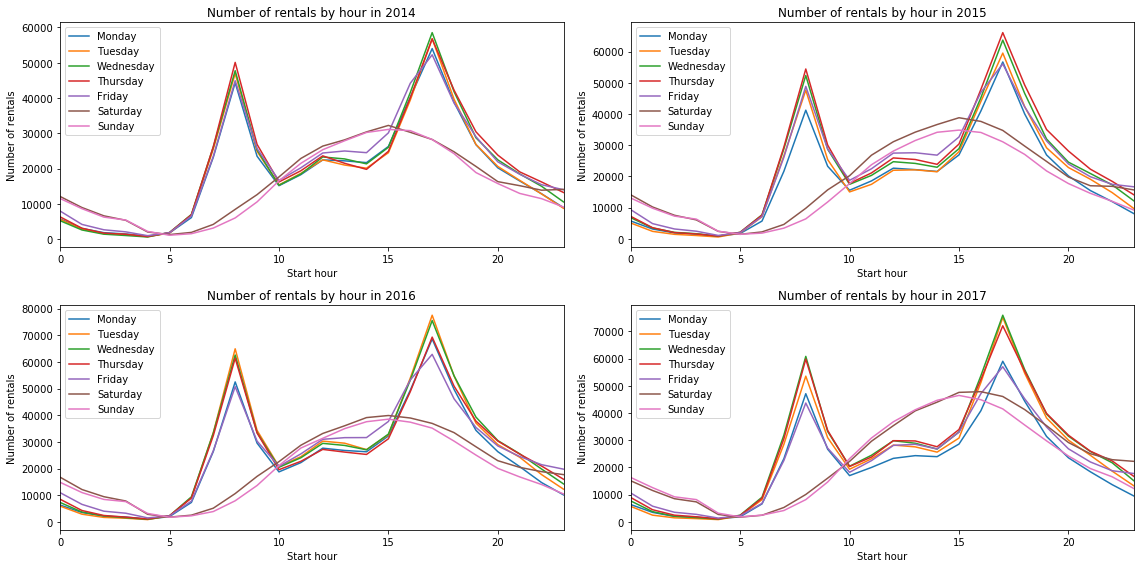

In [5]:
# Exploring number of rentals per weekday

years_rides = (ride_data_2014, ride_data_2015, ride_data_2016, ride_data_2017)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
year = 2014

fig,axes = plt.subplots(figsize=(16, 8), nrows=2, ncols=2)

for i,ride_data in enumerate(years_rides):
    x = int(i / 2)
    y = i % 2 
    plt.sca(axes[x, y])
    ## prep data for plotting
    weekday_data = pd.DataFrame({'start_station_code' : ride_data.start_station_code,
                                 'day_of_week' : ride_data.start_date.dt.strftime("%A"),
                                 'start_hour' : ride_data.start_date.dt.hour})
    a = weekday_data.groupby(['day_of_week','start_hour'])['start_station_code'].count()
    ## generate plot
    #print('\033[1m In {}: \033[0m'.format(year))
    for i in range(len(days)):
        x = a[days[i]].plot(label = days[i])
        #print('Peak on day {} occurs at {}:00 hours'.format( days[i], a[days[i]].idxmax() ))
    plt.title('Number of rentals by hour in {}'.format(year))
    plt.xlabel('Start hour')
    plt.ylabel('Number of rentals')
    year += 1
    plt.legend()
plt.tight_layout()
plt.show()

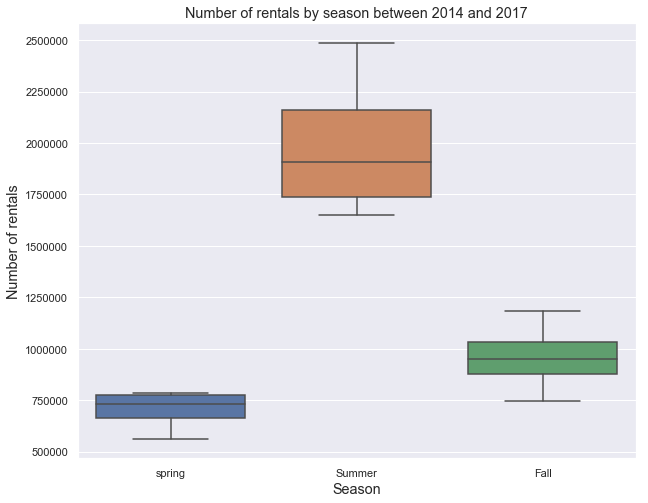

In [106]:
# Exploring average number of rentals per season

years_rides = (ride_data_2014, ride_data_2015, ride_data_2016, ride_data_2017)
year = 2014
seasonal_count = pd.DataFrame(columns = ['count', 'season', 'year'])

for i,ride_data in enumerate(years_rides):
    # add count data per season by year to DataFrame
    df = ride_data.groupby(['season'])['start_date'].count().reset_index().rename(columns={'index': 'season', 'start_date' : 'count'})
    df['year'] = [year] * df.shape[0]
    df['count'] = df['count'].astype(float)
    year += 1
    seasonal_count = seasonal_count.append(df, sort=False)
    
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.boxplot(x="season", y="count", data=seasonal_count)
plt.xlabel('Season', fontsize='large')
plt.ylabel('Number of rentals', fontsize='large')
plt.title('Number of rentals by season between 2014 and 2017', fontsize='large')

plt.xticks(plt.xticks()[0], ('spring', 'Summer', 'Fall'))
plt.show()

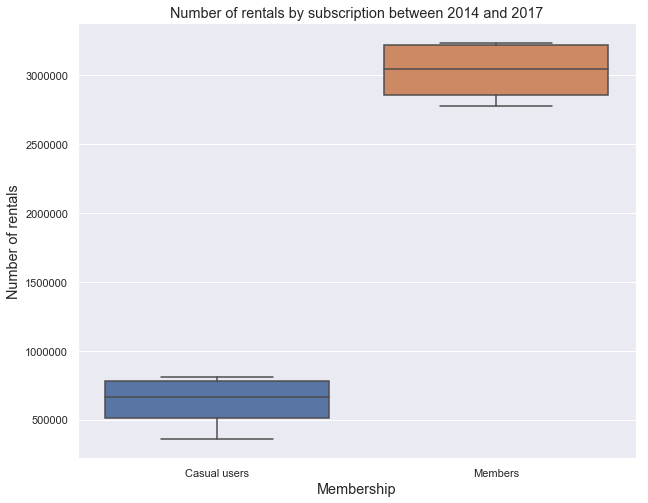

In [123]:
# Exploring average number of rentals for members vs casual users

years_rides = (ride_data_2014, ride_data_2015, ride_data_2016, ride_data_2017)
year = 2014
member_count = pd.DataFrame(columns = ['count', 'membership', 'year'])

for i,ride_data in enumerate(years_rides):
    # add count data per membership by year to DataFrame
    df = ride_data.groupby(['is_member'])['start_date'].count().reset_index().rename(columns={'is_member': 'membership', 'start_date' : 'count'})
    df['year'] = [year] * df.shape[0]
    df['count'] = df['count'].astype(float)
    year += 1
    member_count = member_count.append(df, sort=False)
    
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.boxplot(x="membership", y="count", data=member_count)
plt.xlabel('Membership', fontsize='large')
plt.ylabel('Number of rentals', fontsize='large')
plt.title('Number of rentals by subscription between 2014 and 2017', fontsize='large')

plt.xticks(plt.xticks()[0], ('Casual users', 'Members'))
plt.show()

/Users/wesamazaizeh/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


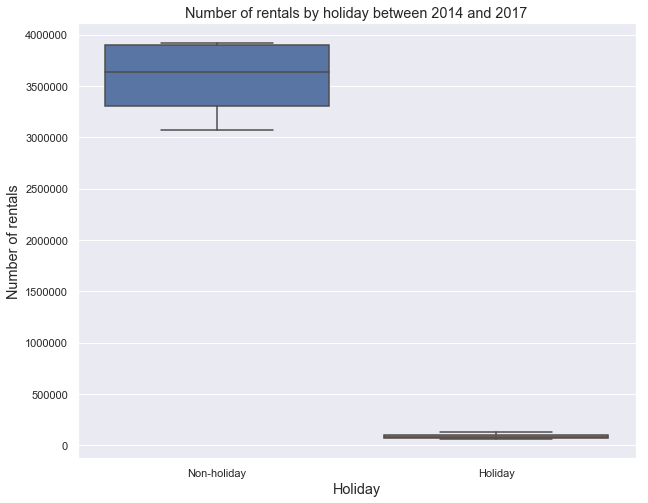

In [122]:
# Exploring average number of rentals on holidays vs. non-holidays

years_rides = (ride_data_2014, ride_data_2015, ride_data_2016, ride_data_2017)
year = 2014
holiday_count = pd.DataFrame(columns = ['count', 'holiday', 'year'])

for i,ride_data in enumerate(years_rides):
    # add count data per holiday by year to DataFrame
    df = ride_data.groupby(['workday'])['start_date'].count().reset_index().rename(columns={'workday': 'holiday', 'start_date' : 'count'})
    df['year'] = [year] * df.shape[0]
    df['count'] = df['count'].astype(float)
    year += 1
    df['count'][0] = df['count'][0] + df['count'][1] 
    df = df.iloc[[0,2]]
    holiday_count = holiday_count.append(df, sort=False)
    
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.boxplot(x="holiday", y="count", data=holiday_count)
plt.xlabel('Holiday', fontsize='large')
plt.ylabel('Number of rentals', fontsize='large')
plt.title('Number of rentals by holiday between 2014 and 2017', fontsize='large')

plt.xticks(plt.xticks()[0], ('Non-holiday', 'Holiday'))
plt.show()

## 5.1. Do members take longer trips on average than casual users?

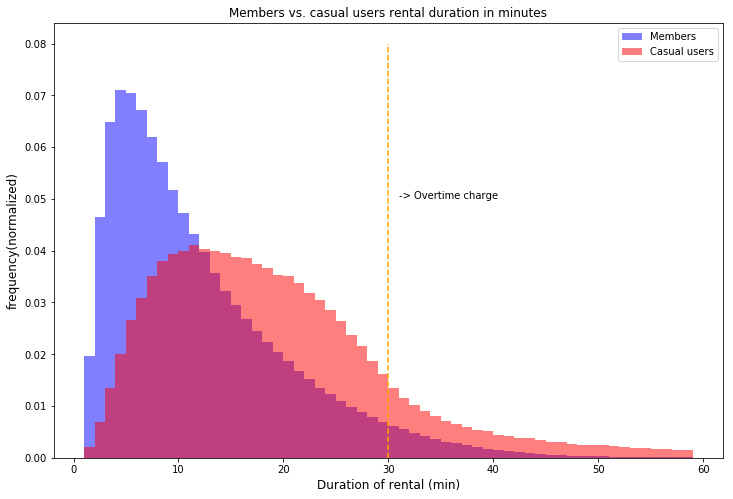

In [16]:
## Compare rental duration distribution for members vs. casual users in 2015
plt.figure(figsize=(12,8))

# prepare data for plotting
member = ride_data_2015.loc[ride_data_2015['is_member'] == 1, 'duration_min']
non_member = ride_data_2015.loc[ride_data_2015['is_member'] == 0, 'duration_min']
# generate histograms
plt.hist(member, density=True, color='blue', bins=np.arange(1, 60), alpha=.5, label='Members') 
plt.hist(non_member, density=True, color='red', bins=np.arange(1, 60), alpha=.5, label='Casual users')
# add line at overtime charge cutoff
plt.plot([30,30],[0,0.08],color = 'orange',linestyle = '--')
plt.text(31,0.05,'-> Overtime charge')
# labeling and customizing plot
plt.grid(b=False)
plt.legend()
plt.title('Members vs. casual users rental duration in minutes', fontsize='large')
plt.xlabel('Duration of rental (min)', fontsize='large')
plt.ylabel('frequency(normalized)', fontsize='large')
plt.show()

In [17]:
member.describe()

count    2.880978e+06
mean     1.222896e+01
std      8.971770e+00
min      1.016667e+00
25%      5.666667e+00
50%      9.800000e+00
75%      1.645000e+01
max      1.199333e+02
Name: duration_min, dtype: float64

In [18]:
non_member.describe()

count    562905.000000
mean         21.397276
std          16.395665
min           1.016667
25%          11.166667
50%          17.783333
75%          25.750000
max         119.983333
Name: duration_min, dtype: float64

- Most rental are below 30 minutes, above which there is an overtime fee. 
- Members keep their commute shorter

In [10]:
# Compute the descriptive statistics of members and non-members
abar = member.mean()
na = member.size
adof = na - 1
avar = member.var(ddof=adof)

bbar = non_member.mean()
nb = non_member.size
bdof = nb - 1
bvar = non_member.var(ddof=bdof)


# Use scipy.stats.ttest_ind_from_stats.
t2, p2 = stats.ttest_ind_from_stats(bbar, np.sqrt(bvar), nb, abar, np.sqrt(avar), na, equal_var=False)
print("t = {:.3}  p = {:.3}".format(t2, p2))

t = 0.491  p = 0.624


- The means of rental duration for members vs non-members are not statistically significantly different

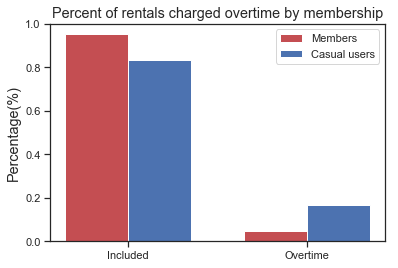

16.7% of casual users pay overtime fee versis 4.75% of subscribers


In [56]:
# Divide date into short vs long trips (> 30 mins) and look at % of rides for members vs. non-members

## Prepare data for plotting
long_trip = np.where( ride_data_2015['duration_min'] > 30, 'long', 'short')
grouped_duration_member = ride_data_2015.groupby(['is_member', long_trip]).count() #counts grouped by ride duration and membership
grouped_duration_member = grouped_duration_member / grouped_duration_member.groupby(level=0).sum() # convert to percentages
unstacked_long_member = grouped_duration_member['start_date'].unstack() 
#generating plot
N = 2
fig, ax = plt.subplots()
ind = np.arange(N)    # the x locations for the groups
width = 0.35          # the width of the bars
p1 = ax.bar(ind, unstacked_long_member.iloc[1][::-1], width, color='r')
p2 = ax.bar(ind + width, unstacked_long_member.iloc[0][::-1], width, color='b')
# labeling and customizing plot
ax.set_title('Percent of rentals charged overtime by membership', fontsize='large')
ax.set_ylabel('Percentage(%)', fontsize='large')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Included', 'Overtime'))
ax.legend((p1[0], p2[0]), ('Members', 'Casual users'))
plt.grid(b=False)
plt.show()
# print quantitative values
print('{:.3}% of casual users pay overtime fee versis {:.3}% of subscribers'.format(unstacked_long_member.iloc[0,0]*100, unstacked_long_member.iloc[1,0]*100))

- However, it is obvious that a much higher percentage of non-members/ casual users pay the overtime fee!

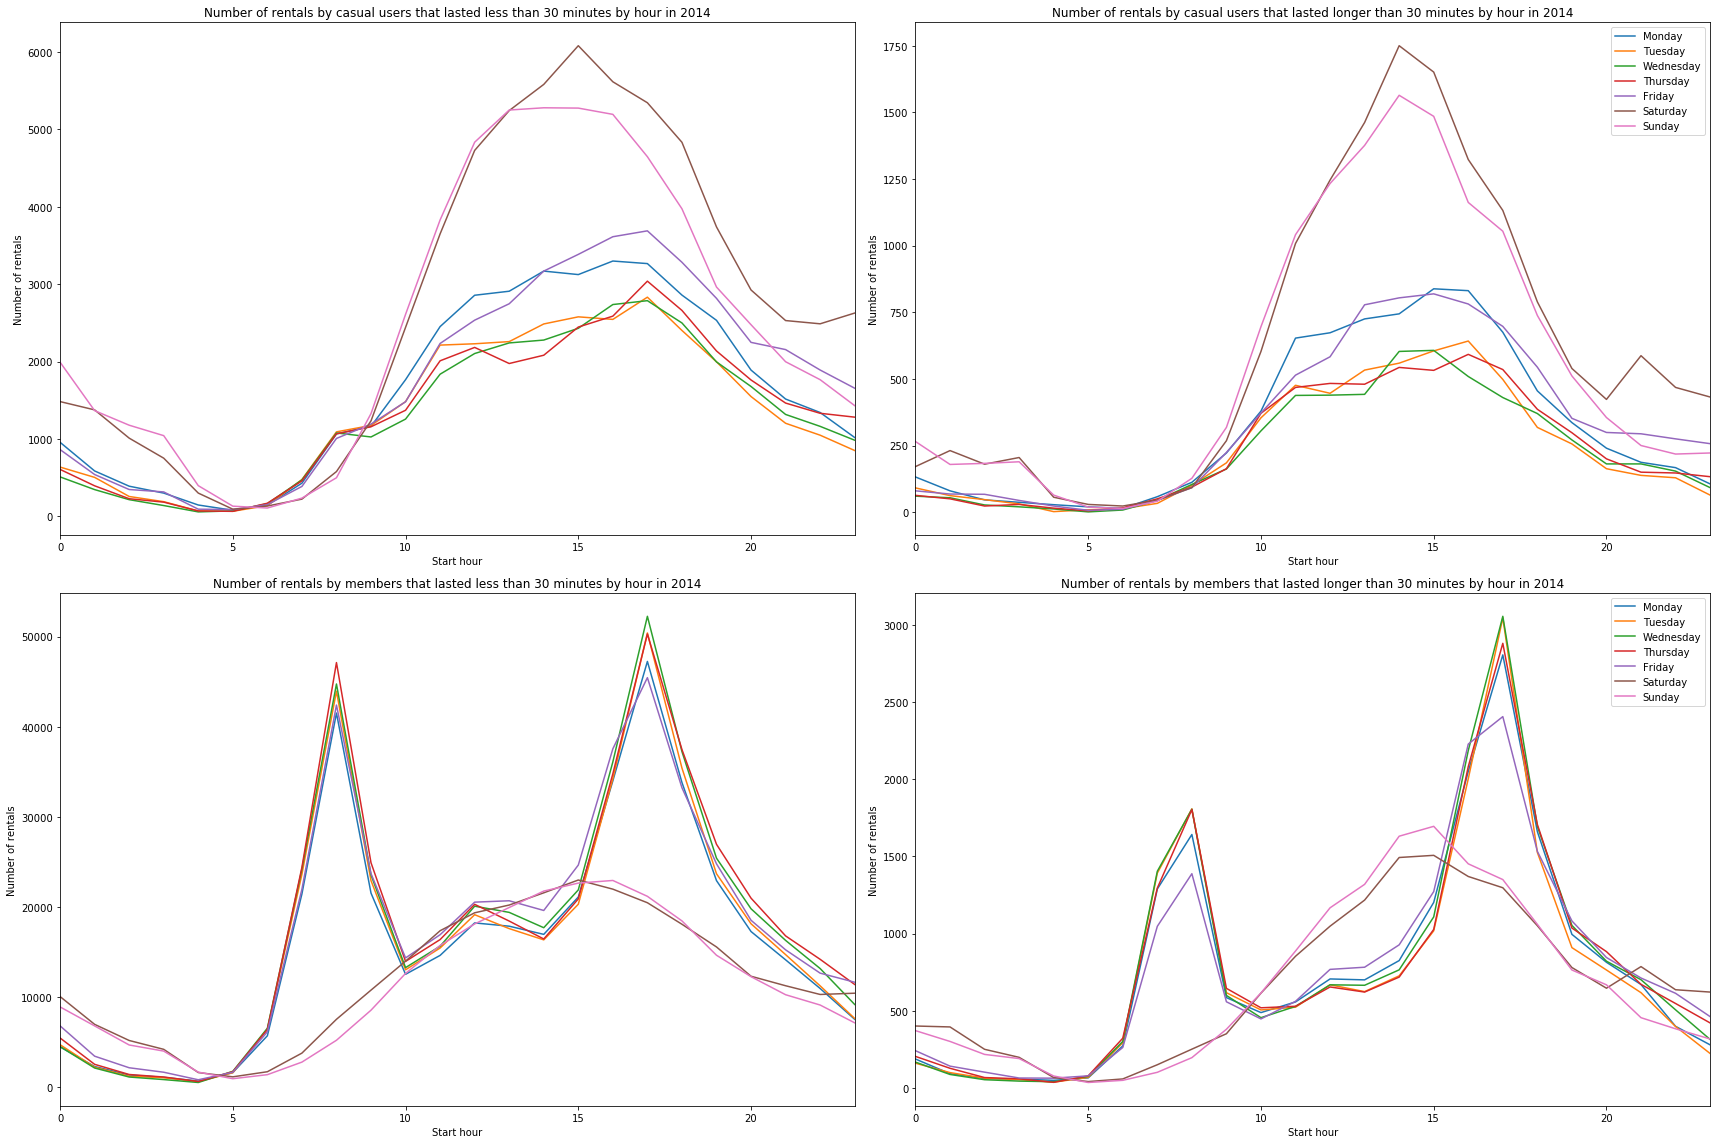

In [36]:
# How do longer duration rental distribute over hours of days of week for members vs. casual users
# Explore in 2014 for simplification

years_rides = (ride_data_2014)
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
year = 2014

fig,axes = plt.subplots(figsize=(24, 16), nrows=2, ncols=2)

for i in range(ride_data_2014.is_member.nunique()):
    ## prep members data for plotting
    plt.sca(axes[i,0])
    weekday_data = ride_data_2014[(ride_data_2014['duration_min'] < 30) & (ride_data_2014['is_member'] == i)]
    weekday_data = pd.DataFrame({'start_station_code' : weekday_data.start_station_code,
                                 'day_of_week' : weekday_data.start_date.dt.strftime("%A"),
                                 'start_hour' : weekday_data.start_date.dt.hour})
    a = weekday_data.groupby(['day_of_week','start_hour'])['start_station_code'].count()
    ## generate plot
    #print('\033[1m In {}: \033[0m'.format(year))
    for y in range(len(days)):
        x = a[days[y]].plot(label = days[y])
        #print('Peak on day {} occurs at {}:00 hours'.format( days[i], a[days[i]].idxmax() ))
    if i == 0:
        plt.title("Number of rentals by casual users that lasted less than 30 minutes by hour in {}".format(year))
    else: 
        plt.title("Number of rentals by members that lasted less than 30 minutes by hour in {}".format(year))
    plt.xlabel('Start hour')
    plt.ylabel('Number of rentals')
    ###########
    ## prep casual users data for plotting
    plt.sca(axes[i,1])
    weekday_data = ride_data_2014[(ride_data_2014['duration_min'] > 30) & (ride_data_2014['is_member'] == i)]
    weekday_data = pd.DataFrame({'start_station_code' : weekday_data.start_station_code,
                                 'day_of_week' : weekday_data.start_date.dt.strftime("%A"),
                                 'start_hour' : weekday_data.start_date.dt.hour})
    a = weekday_data.groupby(['day_of_week','start_hour'])['start_station_code'].count()
    ## generate plot
    #print('\033[1m In {}: \033[0m'.format(year))
    for y in range(len(days)):
        x = a[days[y]].plot(label = days[y])
        #print('Peak on day {} occurs at {}:00 hours'.format( days[i], a[days[i]].idxmax() ))
    if i == 0:
        plt.title("Number of rentals by casual users that lasted longer than 30 minutes by hour in {}".format(year))
    else:
        plt.title("Number of rentals by members that lasted longer than 30 minutes by hour in {}".format(year))
    plt.xlabel('Start hour')
    plt.ylabel('Number of rentals')
    plt.legend()
plt.tight_layout()
plt.show()

- Y-axes are not equal, could be misleading
- It seems that rentals that take longe than 30 minutes peak around ~2pm for both members and casual users
- These rentals are more concentrated in the afternoon area compared to shorter trips
- For members, these trips have a shift towards after work hours. Could be workers that take advantage of the bikes to do after work activties (shopping, going to the bank..)
- would be interesting to investigate the distance correlation with trip time and see if trips that take longer are between further away stations or these users chose to keep the bikes while doing something else along the way.

## 5.2. Does proximity to tourist attraction effect station usage and member vs. non-member ride duration distribution?
### 5.2.1. Improt points of interest in Montreal from Google Places API

In [8]:
### get "points of interest" in Montreal using Google Places API 

# api key & url 
api_key = '*********'
url = "https://maps.googleapis.com/maps/api/place/textsearch/json?"

# saerch for: 
query =  'points of interest in Montreal' #input('Search query: ') 

# download first page and extract data into a DataFrame
res = requests.get(url + 'query=' + query + '&key=' + api_key)  
attractions_json = res.json() # convert response object to python data
attractions_results = attractions_json['results']
attractions_df = pd.DataFrame( columns = ['name', 'latitude', 'longitude'])
for i in range(len(attractions_results)): 
    attractions_df.loc[i] = [attractions_results[i]['name'], attractions_results[i]['geometry']['location']['lat'], attractions_results[i]['geometry']['location']['lng']]
# print(attractions_df.shape) # sanity check

# download and extract data from 2nd & 3rd pages
time.sleep(2) # have to wait before sending next request
while 'next_page_token' in attractions_json:
    page_token = attractions_json['next_page_token']
    res = requests.get(url + 'query=' + query + '&key='+ api_key + '&pagetoken=' + page_token)
    attractions_json = res.json() # convert response object to python data
    attractions_results = attractions_json['results']
    n = len(attractions_df.index) # to add new rows after existing ones
    for i in range(len(attractions_results)): 
        attractions_df.loc[i+n] = [attractions_results[i]['name'], attractions_results[i]['geometry']['location']['lat'], attractions_results[i]['geometry']['location']['lng']]
    # print(attractions_df.shape) # sanity check
    time.sleep(2)

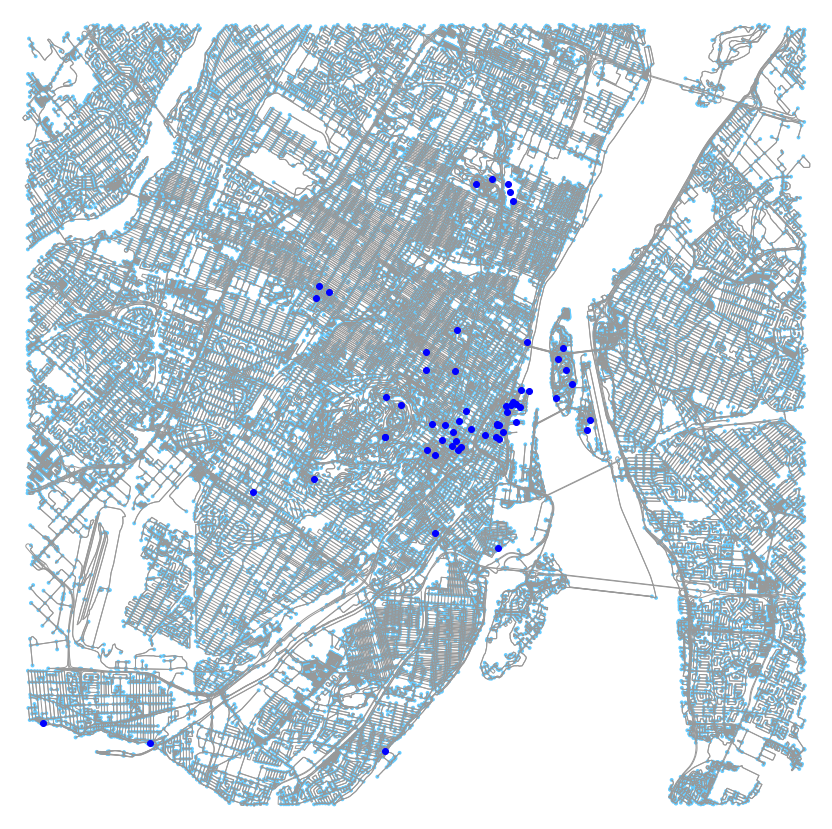

In [15]:
# Street map centered at the midpoint of all bike stations defined by the most recent data

max_lon = stations_2017['longitude'].max()
min_lon = stations_2017['longitude'].min()
max_lat = stations_2017['latitude'].max()
min_lat = stations_2017['latitude'].min()

G2 = ox.graph_from_point((mean([max_lat,min_lat]), mean([max_lon,min_lon])), distance=10000, network_type='all')
fig, ax = ox.plot_graph(G2, fig_height=15, fig_width=20, show=False, close=False)

# add red dots indicating the attractions locations
for index, row in attractions_df.iterrows():
    lon = row['longitude']
    lat = row['latitude']
    ax.scatter(lon, lat, c='blue', zorder=5)
    #ax.scatter(lon, lat,  marker='o', s=200, facecolors='none', edgecolors='r', zorder=5) 
    
plt.show() 

### 5.2.2. Custom function to calculate distances based on lon/ lat

In [10]:
# Define a basic Haversine distance formula
def get_distance(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles

def get_distance_table(features, locations):
    distance_table = pd.DataFrame(index=locations['code'])
    for index, row in features.iterrows():
        col_name = row['name']
        distance_series = get_distance(row['latitude'], row['longitude'], locations['latitude'].values , locations['longitude'].values)
        distance_table[col_name] = list(distance_series)
    return distance_table
                       
distance_table = get_distance_table(attractions_df, stations_2015)

In [11]:
# Define "touristy station" by proximity (<2 miles) to more than 30 city attractions

def proximity_count(distance_table, codes):
    count = [ int( (distance_table.loc[[ code ]] < 2).sum(axis=1) ) for code in codes]
    return count

# Generate a new column in the stations data frame indicating "touristy" status

stations_2015['proximal_count'] = proximity_count(distance_table, stations_2015['code'])
stations_2015['touristy'] = stations_2015['proximal_count'] > 30


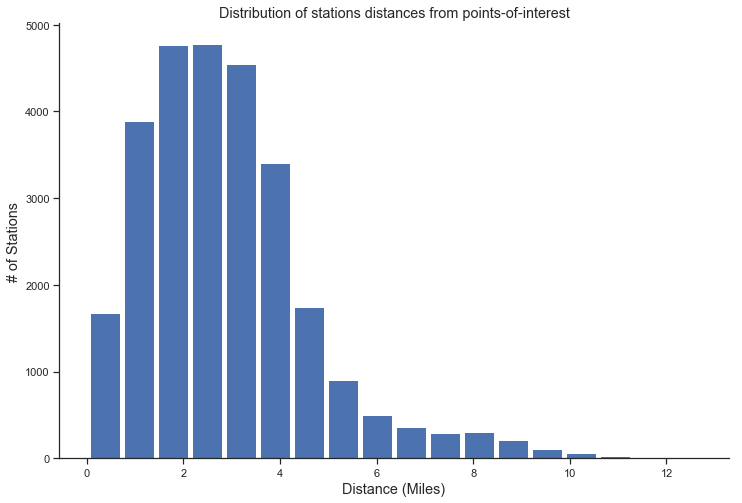

In [47]:
# Histogram of all stations distances from all attractions
plt.figure(figsize=(12,8))

np_distance_table = np.array(distance_table).reshape(-1)
plt.hist(np_distance_table, bins = 18, zorder=2, rwidth=0.9)

# customize plot
sns.set(style='ticks')
sns.despine()
plt.xlabel('Distance (Miles)', fontsize='large')
plt.ylabel('# of Stations', fontsize='large')
plt.title('Distribution of stations distances from points-of-interest', fontsize='large')

plt.show()

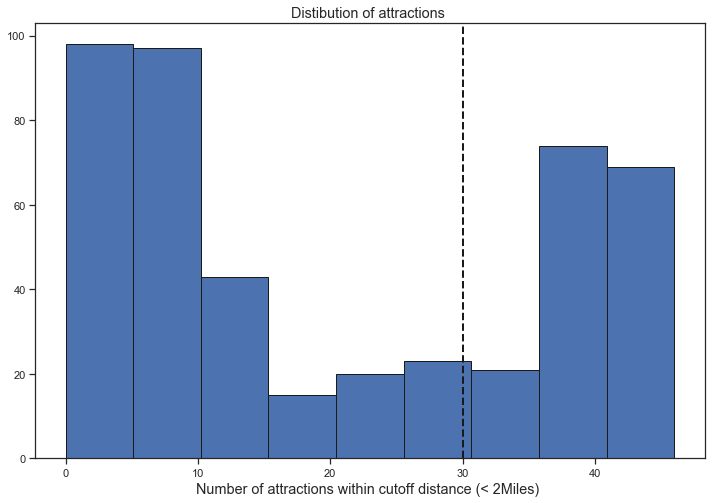

35.7% of stations lie to the right to the cutoff line


In [57]:
#Histogram of number of attractions that are less than 2 miles away from stations.
plt.figure(figsize=(12,8))

plt.hist(stations_2015['proximal_count'], bins=9, edgecolor='k')
plt.axvline(30 , color='k', linestyle='dashed', linewidth=2)
plt.title('Distibution of attractions ', fontsize='large')
plt.xlabel('Number of attractions within cutoff distance (< 2Miles) ', fontsize='large')
plt.show()
print('{:.3}% of stations lie to the right to the cutoff line'.format(stations_2015[ stations_2015['proximal_count'] > 30 ].count()[0]/len(stations_2015.index)*100))

In [ ]:
# use this section to imperically decide ax.scatter.s(ize) 
G3 = ox.graph_from_point((mean([max_lat,min_lat]), mean([max_lon,min_lon])), distance=10000, network_type='all')

fig, ax = ox.plot_graph(G3, fig_height=15, fig_width=20, edge_alpha= 0.5, show=False, close=False)

# add one points for the first attraction on the map
lon = attractions_df['longitude'].iloc[0]
lat = attractions_df['latitude'].iloc[0]
ax.scatter(lon, lat, marker='o', s=70000, facecolors='b', edgecolors='b', alpha = 0.3, zorder=5) 

# add stations that are less than 2 miles away from this attraction
mask = np.where( distance_table[attractions_df.name.iloc[0]] < 2 , True, False)
for index, row in stations_2015[mask].iterrows():
    lon = row['longitude']
    lat = row['latitude']
    ax.scatter(lon, lat, c='red')
    
plt.show()

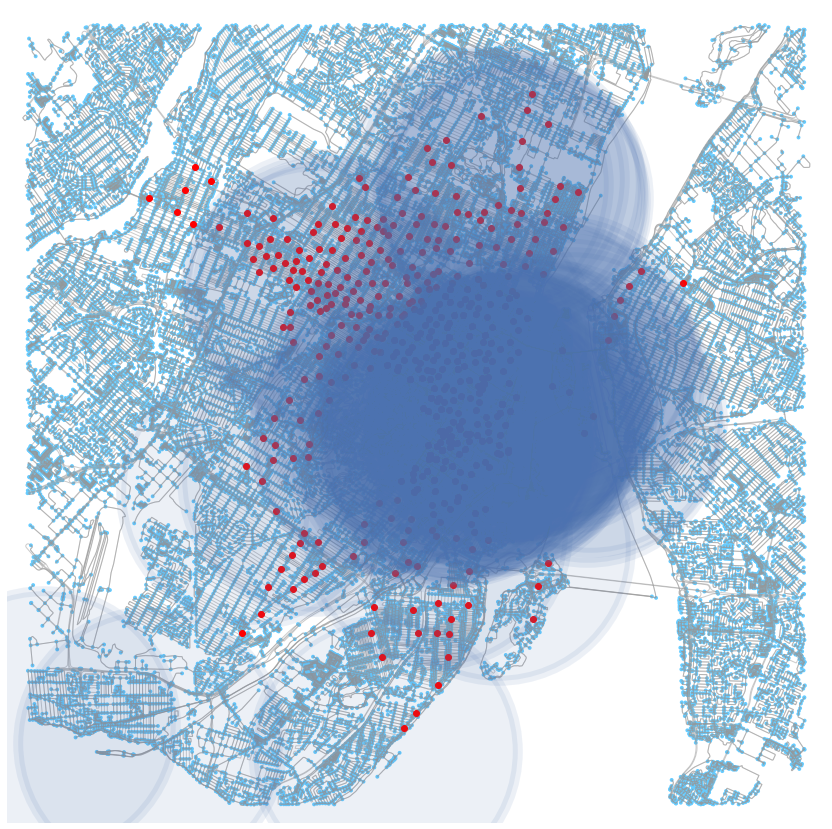

In [55]:
# Plot stations and points-of-interest of the map 
G3 = ox.graph_from_point((mean([max_lat,min_lat]), mean([max_lon,min_lon])), distance=10000, network_type='all')

fig, ax = ox.plot_graph(G3, fig_height=15, fig_width=20, edge_alpha= 0.5, show=False, close=False)

# add points indicating ride_data stations to map
for index, row in stations_2015.iterrows():
    lon = row['longitude']
    lat = row['latitude']
    ax.scatter(lon, lat, c='red', zorder=4)
# add points indicating attractions
for index, row in attractions_df.iterrows():
    lon = row['longitude']
    lat = row['latitude']
    ax.scatter(lon, lat, marker='o', s=70000, facecolors='b', edgecolors='b', alpha = 0.1, linewidth='10', zorder=5) 
plt.show()

In [13]:
# Add column with "touristy" status to each ride according to start station proximity test
ride_data_2015['touristy_start'] = ride_data_2015.start_station_code.map(stations_2015.set_index('code')['touristy'].to_dict())
ride_data_2015['touristy_start'] = ride_data_2015['touristy_start'].replace({True: 1, False: 0})
ride_data_2015['is_member'] = ride_data_2015['is_member'].replace({True: 1, False: 0})

# Convert touristy_start and is_member column types to categorial for sns.countplot to understand them
ride_data_2015['touristy_start'] = ride_data_2015.touristy_start.astype('category')
ride_data_2015['is_member'] = ride_data_2015.is_member.astype('category')

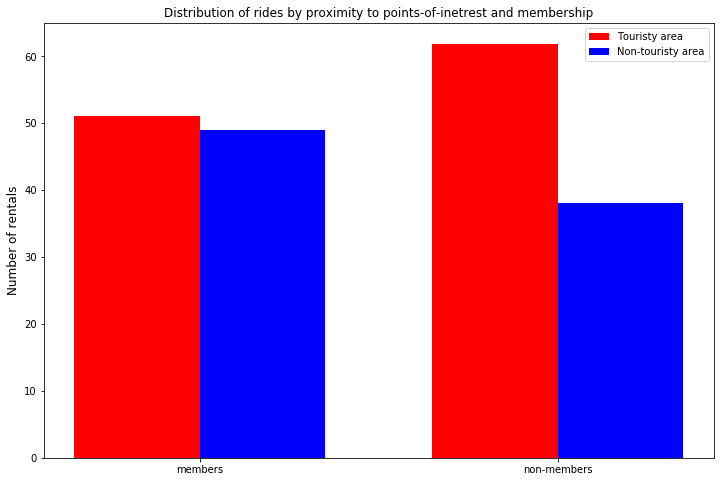

In [14]:
# Barplot of count of members vs casual users in touristy vs. local areas

# Prepare data for plotting
grouped_touristy_member = ride_data_2015.groupby(['touristy_start','is_member'])['start_date'].count()
grouped_touristy_member = grouped_touristy_member.unstack() 
grouped_touristy_member[0] = 100 * grouped_touristy_member[0]/ grouped_touristy_member[0].sum() 
grouped_touristy_member[1] = 100 * grouped_touristy_member[1]/ grouped_touristy_member[1].sum() 



N = 2
fig, ax = plt.subplots(figsize=(12,8))

ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, grouped_touristy_member.iloc[1][::-1], width, color='r')
p2 = ax.bar(ind + width, grouped_touristy_member.iloc[0][::-1], width, color='b')

ax.set_title('Distribution of rides by proximity to points-of-inetrest and membership', fontsize='large')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('members', 'non-members'))
ax.set_ylabel('Number of rentals', fontsize='large')

ax.legend((p1[0], p2[0]), ('Touristy area', 'Non-touristy area'))
ax.autoscale_view()

plt.show()

***
## 5.3 Season, workday, and holiday trends exploration

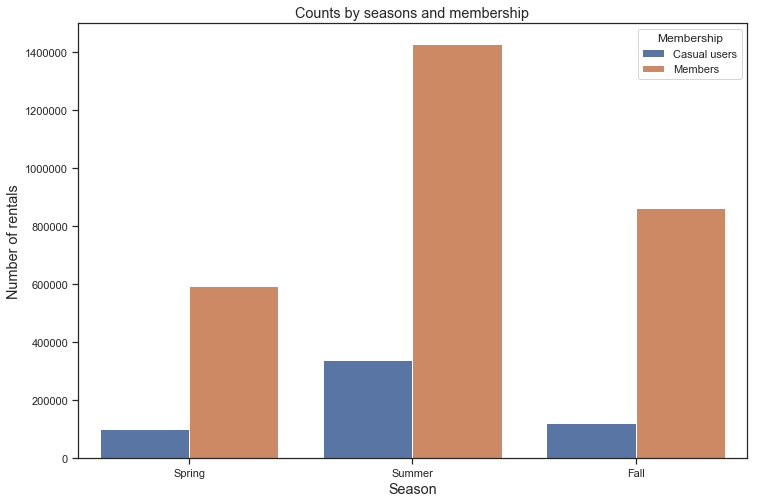

In [70]:
# plotting count vs. season
plt.figure(figsize=(12,8))

season_data = ride_data_2015[['season', 'is_member']]
ax = sns.countplot(x="season", hue="is_member", data=season_data)

# Annotate plot
ax.set_title( 'Counts by seasons and membership', fontsize='large')
ax.set_xticklabels(['Spring', 'Summer', 'Fall'])
ax.set_xlabel('Season', fontsize='large')
ax.set_ylabel('Number of rentals', fontsize='large')
plt.legend(title='Membership', loc='upper right', labels=['Casual users', 'Members'])
plt.show()

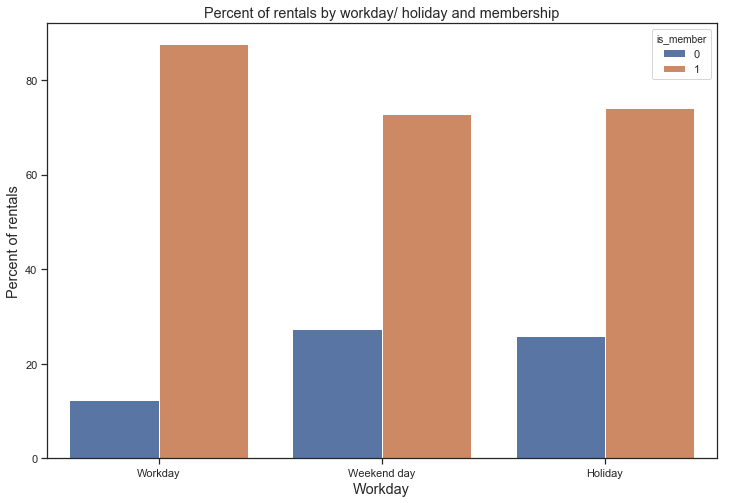

In [76]:
# plotting percent rentals vs. holiday by membership
plt.figure(figsize=(12,8))

holiday_data1 = ride_data_2015.groupby(['workday', 'is_member']).size().reset_index(name='start_date')
a = holiday_data1.groupby('workday')['start_date'].transform('sum')
holiday_data1['start_date'] = holiday_data1['start_date'].div(a)*100
ax =sns.barplot(x='workday', y='start_date', hue='is_member', data=holiday_data1)

# Annotate plot
ax.set_title( 'Percent of rentals by workday/ holiday and membership', fontsize='large')
ax.set_xticklabels(['Workday', 'Weekend day', 'Holiday'])
ax.set_xlabel('Workday', fontsize='large')
ax.set_ylabel('Percent of rentals', fontsize='large')
plt.show()

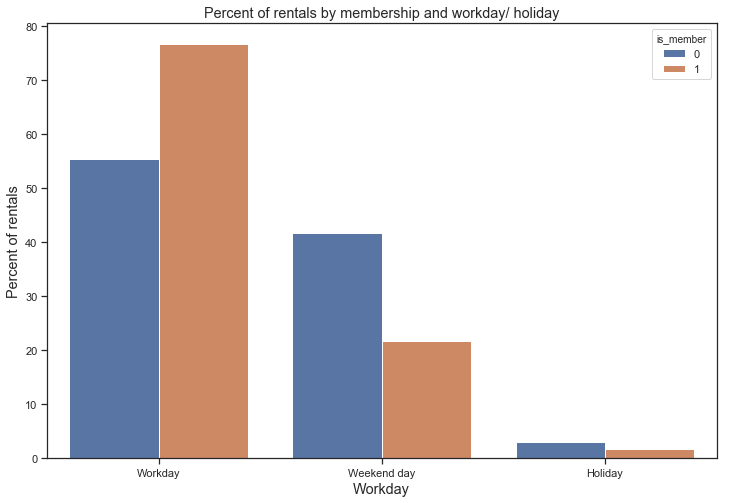

In [78]:
# plotting percent rentals vs. membership by holiday
plt.figure(figsize=(12,8))

holiday_data2 = ride_data_2015.groupby(['is_member', 'workday']).size().reset_index(name='start_date')
a = holiday_data2.groupby('is_member')['start_date'].transform('sum')
holiday_data2['start_date'] = holiday_data2['start_date'].div(a)*100
ax =sns.barplot(x='workday', y='start_date', hue='is_member', data=holiday_data2)

# Annotate plot
ax.set_title( 'Percent of rentals by membership and workday/ holiday', fontsize='large')
ax.set_xticklabels(['Workday', 'Weekend day', 'Holiday'])
ax.set_xlabel('Workday', fontsize='large')
ax.set_ylabel('Percent of rentals', fontsize='large')
plt.show()

## 6. Future Research:

Trips in this data set do not have user/ bike identifiers. This limits possible route analysis as we cannot differentiate between users that take multiple short trips versus ones that take single long trips, etc...

For each trip, start station and end station IDs are available. This data can be used to analyze member vs casual user rental patterns. I would expect casual users to have a higher correlation between certain stations, those that are proximal to tourist attractions.

